In [2]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting
! unzip walmart-recruiting-store-sales-forecasting.zip
! rm walmart-recruiting-store-sales-forecasting.zip
! unzip features.csv.zip
! rm features.csv.zip
! unzip train.csv.zip
! rm train.csv.zip
! unzip test.csv.zip
! rm test.csv.zip
! unzip sampleSubmission.csv.zip
! rm sampleSubmission.csv.zip

Mounted at /content/drive
  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 648MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


## **Imports**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

In [5]:
TRAIN_SIZE = 0.7

In [6]:
train['Date'] = pd.to_datetime(train['Date'])

In [7]:
class TimeSeriesSplit:
    def __init__(self, train_size:int) -> None:
        self.train_size = train_size
        self.val_size = 1 - train_size

    def split(self, data:pd.DataFrame) -> tuple[pd.DataFrame,pd.DataFrame]:
        # data['Date'] = pd.to_datetime(data['Date'])
        data = data.copy().sort_values(by='Date')
        start_week = data['Date'].min()
        end_week = data['Date'].max()
        data['DateDummy'] = ((data['Date'] - start_week).dt.days // 7).astype(int)
        train_data = data.iloc[:int(self.train_size*data.shape[0])]
        val_data = data.iloc[int(self.train_size*data.shape[0]):]
        return train_data, val_data

In [8]:
class Filter:
  def get_query(self) -> str:
    pass

In [9]:
class DataFilter:
    def filter(self, data:pd.DataFrame, filter:Filter) -> pd.DataFrame:
        return data.query(filter.get_query())

In [10]:
class ComposeFilter(Filter):
    def __init__(self, filter_list:list[Filter]) -> None:
        self.filter_list = filter_list

    def get_query(self) -> str:
        return ' and '.join([filter.get_query() for filter in self.filter_list])

In [11]:
class StoreFilter(Filter):
    def __init__(self, store_id:int) -> None:
        self.store_id = store_id

    def get_query(self) -> str:
        return f'Store=={self.store_id}'

In [12]:
class DeptFilter(Filter):
    def __init__(self, dept_id:int) -> None:
        self.dept_id = dept_id

    def get_query(self) -> str:
        return f'Dept=={self.dept_id}'

In [13]:
from functools import reduce
class DeptKeeper:
    def __init__(self, data:pd.DataFrame,train_size:int,dept_id:int) -> None:
        self.train_mapping:dict[int,pd.DataFrame] = {}
        self.val_mapping:dict[int,pd.DataFrame] = {}
        for store in data['Store'].unique():
            compose_filter = ComposeFilter([StoreFilter(store),DeptFilter(dept_id)])
            filtered = DataFilter().filter(data, compose_filter)
            train_part, val_part = TimeSeriesSplit(train_size).split(filtered)
            self.train_mapping[store] = train_part
            self.val_mapping[store] = val_part

    def get_train(self,store_id:int) -> pd.DataFrame:
        return self.train_mapping[store_id].copy()

    def get_val(self,store_id:int) -> pd.DataFrame:
        return self.val_mapping[store_id].copy()

    def get_train_keys(self) -> list[int]:
        return list(self.train_mapping.keys())

    def get_val_keys(self) -> list[int]:
        return list(self.val_mapping.keys())

    def get_train_avarage(self) -> pd.DataFrame:
        dfs = [self.get_train(s)[['Date','Weekly_Sales']] for s in self.get_train_keys()]
        return self.__calc_avarage(dfs)

    def get_val_avarage(self) -> pd.DataFrame:
        dfs = [self.get_val(s)[['Date','Weekly_Sales']] for s in self.get_val_keys()]
        return self.__calc_avarage(dfs)

    def __calc_avarage(self,data:pd.DataFrame) -> pd.DataFrame:
        for i, df in enumerate(data):
            df.rename(columns={'Weekly_Sales': f'Sales{i+1}'}, inplace=True)

        merged = reduce(lambda left, right: pd.merge(left, right, on='Date'), data)

        merged['Avg_Sales'] = merged[[col for col in merged.columns if col.startswith('Sales')]].mean(axis=1)
        return merged

In [14]:
dept1 = DeptKeeper(train,TRAIN_SIZE,1)

/tmp/ipython-input-15-1551910357.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', N)  # 20 distinct colors


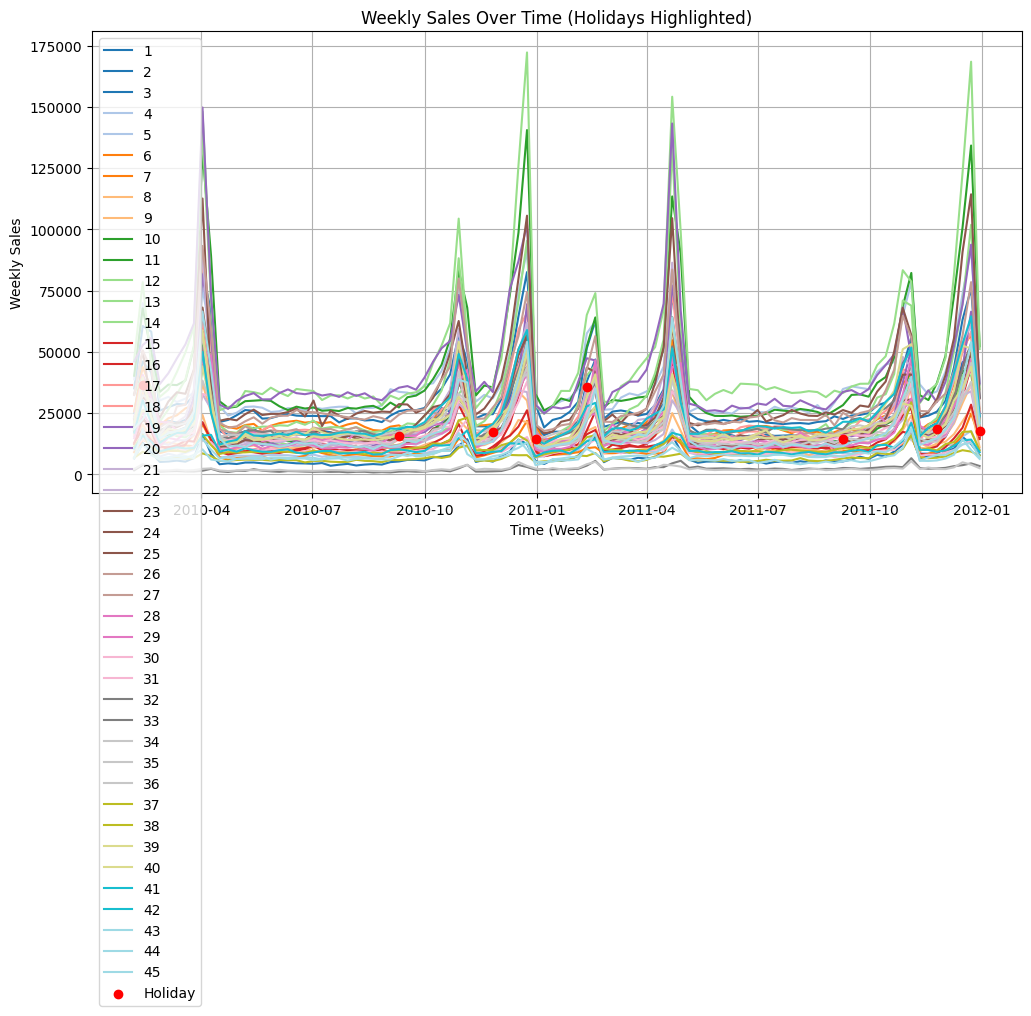

In [15]:
N = 45
cmap = plt.cm.get_cmap('tab20', N)  # 20 distinct colors

colors = [cmap(i) for i in range(N)]
holidays = dept1.get_train(22)[dept1.get_train(22)['IsHoliday'] == True]

plt.figure(figsize=(12, 6))
for s in sorted(dept1.get_train_keys()):
  plt.plot(dept1.get_train(s)['Date'], dept1.get_train(s)['Weekly_Sales'], label=f'{s}', color=colors[s-1])

plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color='red', label='Holiday', zorder=5)
plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
merged = dept1.get_train_avarage()

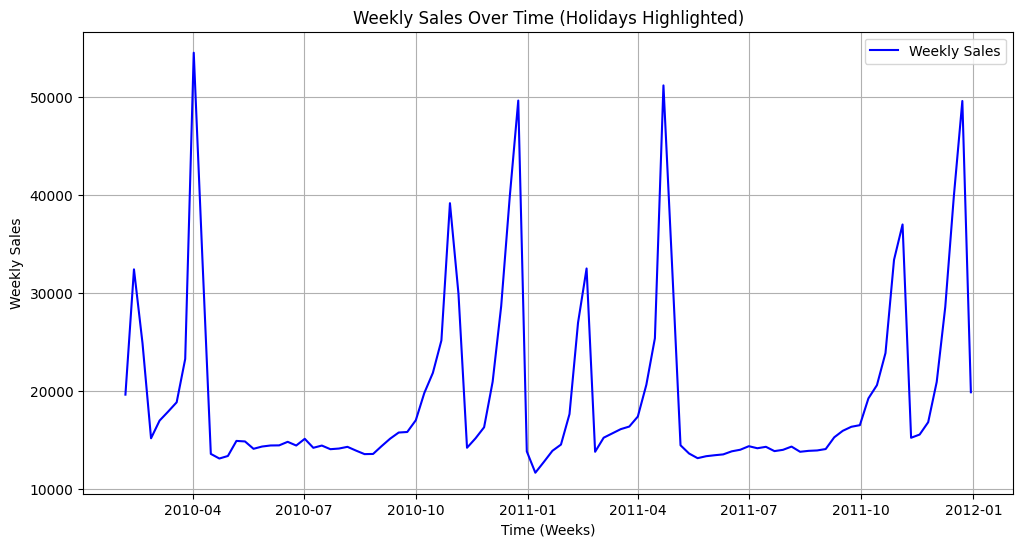

In [17]:
# holidays = dept1.get_train(1)[train_part['IsHoliday'] == True]

plt.figure(figsize=(12, 6))
plt.plot(merged['Date'], merged['Avg_Sales'], label='Weekly Sales', color='blue')
# plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color='red', label='Holiday', zorder=5)

plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(merged['Avg_Sales'].dropna())

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("✅ Series is likely stationary (reject H0)")
else:
    print("❌ Series is likely non-stationary (fail to reject H0)")

ADF Statistic: -6.415004023574228
p-value: 1.8505901642426476e-08
✅ Series is likely stationary (reject H0)


<Figure size 1000x500 with 0 Axes>

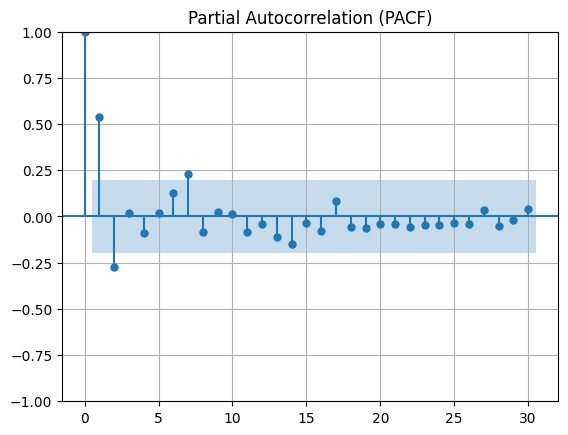

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 5))
plot_pacf(merged['Avg_Sales'], lags=30, method='ywm')  # or method='ld', 'ols', etc.
plt.title("Partial Autocorrelation (PACF)")
plt.grid(True)
plt.show()

In [20]:
def create_data(avarage:pd.DataFrame, one_of:pd.DataFrame)->pd.DataFrame:
    x = pd.DataFrame()

    x['lag1'] = avarage['Avg_Sales'].shift(1)
    x['lag2'] = avarage['Avg_Sales'].shift(2)
    x['lag7'] = avarage['Avg_Sales'].shift(7)
    x['Holiday'] = one_of['IsHoliday'].astype(int)
    x['TimeDummy'] = one_of['DateDummy']
    x['Year'] = one_of['Date'].dt.year
    x['Month'] = one_of['Date'].dt.month

    x.index = avarage['Date']
    x.bfill(inplace=True)

    y = avarage['Avg_Sales'].bfill()

    return x, y

In [23]:
x_train, y_train = create_data(dept1.get_train_avarage(), dept1.get_train(1))
x_val, y_val = create_data(dept1.get_val_avarage(), dept1.get_val(1))

In [24]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error

In [26]:
model = XGBRegressor(
    n_estimators=88,
    learning_rate=0.01,
    max_depth=5,
    objective='reg:squarederror',
    random_state=42,
)

model.fit(x_train, y_train,
          eval_set=[(x_train, y_train), (x_val, y_val)],
        verbose=False)

y_train_predict = model.predict(x_train)
y_val_predict = model.predict(x_val)
train_score = mean_absolute_error(y_train, y_train_predict)
val_score = mean_absolute_error(y_val, y_val_predict)
print(f"Train MSE: {train_score}, Val MSE: {val_score}")

Train MSE: 3142.802347916667, Val MSE: 3308.92917042151


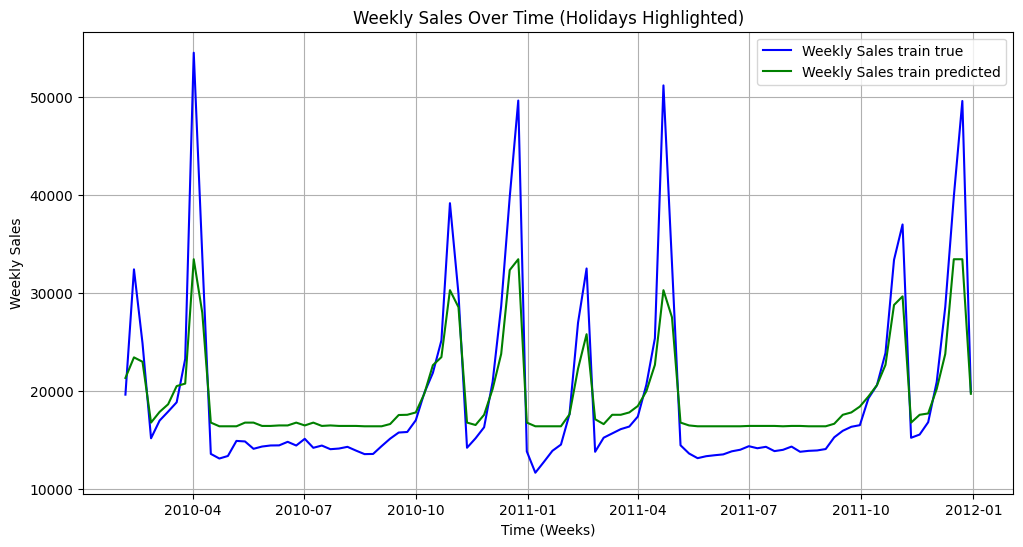

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(merged['Date'], merged['Avg_Sales'], label='Weekly Sales train true', color='blue')
plt.plot(merged['Date'], y_train_predict, label='Weekly Sales train predicted', color='green')
# plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color='red', label='Holiday', zorder=5)

plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

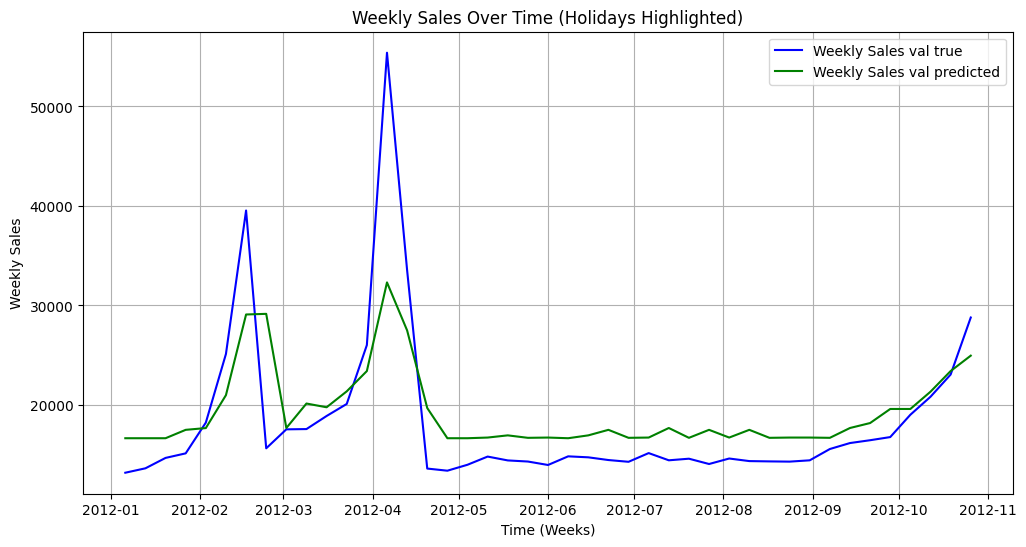

In [28]:
val_avaraged = dept1.get_val_avarage()

plt.figure(figsize=(12, 6))
plt.plot(dept1.get_val(1)['Date'], val_avaraged['Avg_Sales'], label='Weekly Sales val true', color='blue')
plt.plot(dept1.get_val(1)['Date'], y_val_predict, label='Weekly Sales val predicted', color='green')
# plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color='red', label='Holiday', zorder=5)

plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()